## Import and Definitions

In [1]:
import numpy as np

# https://github.com/ppark-twosixtech/armory/tree/e85c983ff7442ac2c50bef041bd049936d4f9255
from armory.metrics import task
from tidecv import TIDE
import tidecv.data

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

2022-11-20 04:15:20  0s INFO     armory.delayed_imports:<module>:7 Importing and configuring torch, tensorflow, and art, if available. This may take some time.
2022-11-20 04:15:22  3s INFO     armory.delayed_imports:<module>:30 Setting tf.config.experimental.set_memory_growth to True on all GPUs
2022-11-20 04:15:22  3s INFO     art.config:set_data_path:55 set ART_DATA_PATH to /tmp/.art/data
2022-11-20 04:15:23  3s INFO     art.config:set_data_path:55 set ART_DATA_PATH to /armory/saved_models/art


In [2]:
def generate_square(x1, y1, l=10):
    return x1, y1, x1+l, y1+l

In [3]:
def generate_square_from_iou(square, iou, x3, y3_le_y1=True):
    x1, y1, x2, y2 = square
    l = x2 - x1    # side of a square
    A1 = A2 = l**2 # restrict to squares of the same size
    
    if x3 <= x1:
        s_x = 1
    else:
        s_x = -1
        
    if y3_le_y1:
        s_y = 1
    else:
        s_y = -1
        
    # in this restricted problem, delta_x needs to satisfy certain constraints
    delta_x = abs(x1 - x3)
    max_delta_x = l*(1 - iou)/(1 + iou)
    print(f"delta_x <= {max_delta_x}: {delta_x <= max_delta_x}")
    
    # y3 = s_y*(iou*(A1 + A2)/(1 + iou)/(l + s_x*(x3 - x1)) - (l - s_y*y1))
    # y3 = s_y*(iou*(A1 + A2)/(1 + iou)/(l - s_x*(x1 - x3)) - (l - s_y*y1))
    # y3 = s_y*(iou*(A1 + A2)/(1 + iou)/(l - abs(x1 - x3)) - (l - s_y*y1))
    y3 = y1 + s_y*(iou*(A1 + A2)/(1 + iou)/(l - delta_x) - l)
    
    if (not y3_le_y1 and y3 > y1) or (y3_le_y1 and y3 <= y1):
        return x3, y3, x3+l, y3+l
    else:
        return None

In [4]:
def calculate_iou(s1, s2):
    x1, y1, x2, y2 = s1
    x3, y3, x4, y4 = s2
    
    A1 = abs(x2 - x1) * abs(y2 -y1)
    A2 = abs(x4 - x3) * abs(y4 -y3)
    
    I_w = max(0, min(max(x1,x2), max(x3,x4)) - max(min(x1,x2), min(x3,x4)))
    I_h = max(0, min(max(y1,y2), max(y3,y4)) - max(min(y1,x2), min(y3,y4)))
    I = I_w * I_h
    
    # I = abs(min(max(x1,x2), max(x3,x4)) - max(min(x1,x2), min(x3,x4))) * abs(min(max(y1,y2), max(y3,y4)) - max(min(y1,x2), min(y3,y4)))
    
    return np.round(I/(A1 + A2 - I), decimals=2), A1, A2, I_w, I_h, I

In [5]:
def get_patch(square, lw=2, ec="r", ls="-", fc="none", a=1):
    x = square[0]
    y = square[1]
    w = square[2]-square[0]
    h = square[3]-square[1]
    return patches.Rectangle((x, y), w, h, linewidth=lw, edgecolor=ec, linestyle=ls, facecolor=fc, alpha=a)

In [6]:
def get_detection_patch(square, c="r"):
    return get_patch(square, ec=c, ls=(5, (10, 3)))
    # return get_patch(square, ec=c, ls="--")

In [7]:
def get_gt_patch(square, c="r", a=0.5):
    # return get_patch(square, ec=c, fc=c)
    # return get_patch(square, lw=0, fc=c)
    return get_patch(square, lw=0, fc=c, a=a)
    # return get_patch(square, ec=c)

In [8]:
def dict_to_list(y_dict):
    return [dict(zip(y_dict, v)) for v in zip(*y_dict.values())]

def plot_tide_case(y_dict, y_pred_dict, class_color_map={1: "cyan", 2: "magenta", 3: "yellow"}):
    y_list = dict_to_list(y_dict)
    y_pred_list = dict_to_list(y_pred_dict)
    
    fig = plt.figure(figsize=(16,6))
    fs = 20
    # fig = plt.figure(figsize=(8,3))
    # fs = 10
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Create patch
    gt_patch_list = [get_gt_patch(y["boxes"], class_color_map[y["labels"]]) for y in y_list]
    detection_patch_list = [get_detection_patch(y["boxes"], class_color_map[y["labels"]]) for y in y_pred_list]

    # Add the patch to the Axes
    for patch in gt_patch_list + detection_patch_list:
        ax.add_patch(patch)
        
    for y_pred in y_pred_list:
        s_gt = y_list[y_pred["max_IOU_idx"]]["boxes"]
        s_pred = y_pred["boxes"]
        annotation_xy = y_pred["annotation_xy"]
        c_pred = class_color_map[y_pred["labels"]]
        ax.annotate(calculate_iou(s_gt, s_pred)[0], annotation_xy, size=fs, color=c_pred)
    
    ax.set_xlim(0,80)
    ax.set_ylim(0,30)

## Generate Boxes

In [10]:
x1 = y1 = 10

s1 = generate_square(x1,y1)
s_Cls = generate_square_from_iou(s1, 0.8, x1-0.5, False)
print(s_Cls, calculate_iou(s1, s_Cls))
s_Loc = generate_square_from_iou(s1, 0.2, x1-4.5)
print(s_Loc, calculate_iou(s1, s_Loc))
s_Bkg = generate_square_from_iou(s1, 0.05, x1+6.8, False)
print(s_Bkg, calculate_iou(s1, s_Bkg))

x2 = 35
s2 = generate_square(x2,y1)
s_detected = generate_square_from_iou(s2, 0.8, x2-0.5, False)
print(s_detected, calculate_iou(s2, s_detected))
s_Dupe = generate_square_from_iou(s2, 0.55, x2+2)
print(s_Dupe, calculate_iou(s2, s_Dupe))
s_Both = generate_square_from_iou(s2, 0.2, x2-4.5)
print(s_Both, calculate_iou(s2, s_Both))

x3 = 60
s3 = generate_square(x3,y1)

delta_x <= 1.111111111111111: True
(9.5, 10.64327485380117, 19.5, 20.64327485380117) (0.8, 100, 100.0, 9.5, 9.35672514619883, 88.88888888888889)
delta_x <= 6.666666666666667: True
(5.5, 6.060606060606061, 15.5, 16.060606060606062) (0.2, 100, 100.0, 5.5, 6.060606060606062, 33.33333333333334)
delta_x <= 9.047619047619047: True
(16.8, 17.023809523809526, 26.8, 27.023809523809526) (0.05, 100, 100.0, 3.1999999999999993, 2.9761904761904745, 9.523809523809517)
delta_x <= 1.111111111111111: True
(34.5, 10.64327485380117, 44.5, 20.64327485380117) (0.8, 100, 100.0, 9.5, 9.35672514619883, 88.88888888888889)
delta_x <= 2.903225806451613: True
(37, 8.870967741935484, 47, 18.870967741935484) (0.55, 100, 100.0, 8, 8.870967741935484, 70.96774193548387)
delta_x <= 6.666666666666667: True
(30.5, 6.060606060606061, 40.5, 16.060606060606062) (0.2, 100, 100.0, 5.5, 6.060606060606062, 33.33333333333334)


## Test Case: `mAP = 17`

In [11]:
y_list = [
        {
        "labels": np.array([1, 2, 3]),
        "boxes": np.array(
            [
                s1,
                s2,
                s3,
            ]
        ),
    }
]

y_pred_list = [
    {
        "labels": np.array([2, 1, 1, 2, 2, 1]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Bkg,
                s_detected,
                s_Dupe,
                s_Both,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 0, 0, 1, 1, 1],
        "annotation_xy": [
            (s_Cls[0], s_Cls[3] + 0.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Bkg[2] - 3, s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[2] - 3, s_Dupe[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
        ]
    }
]

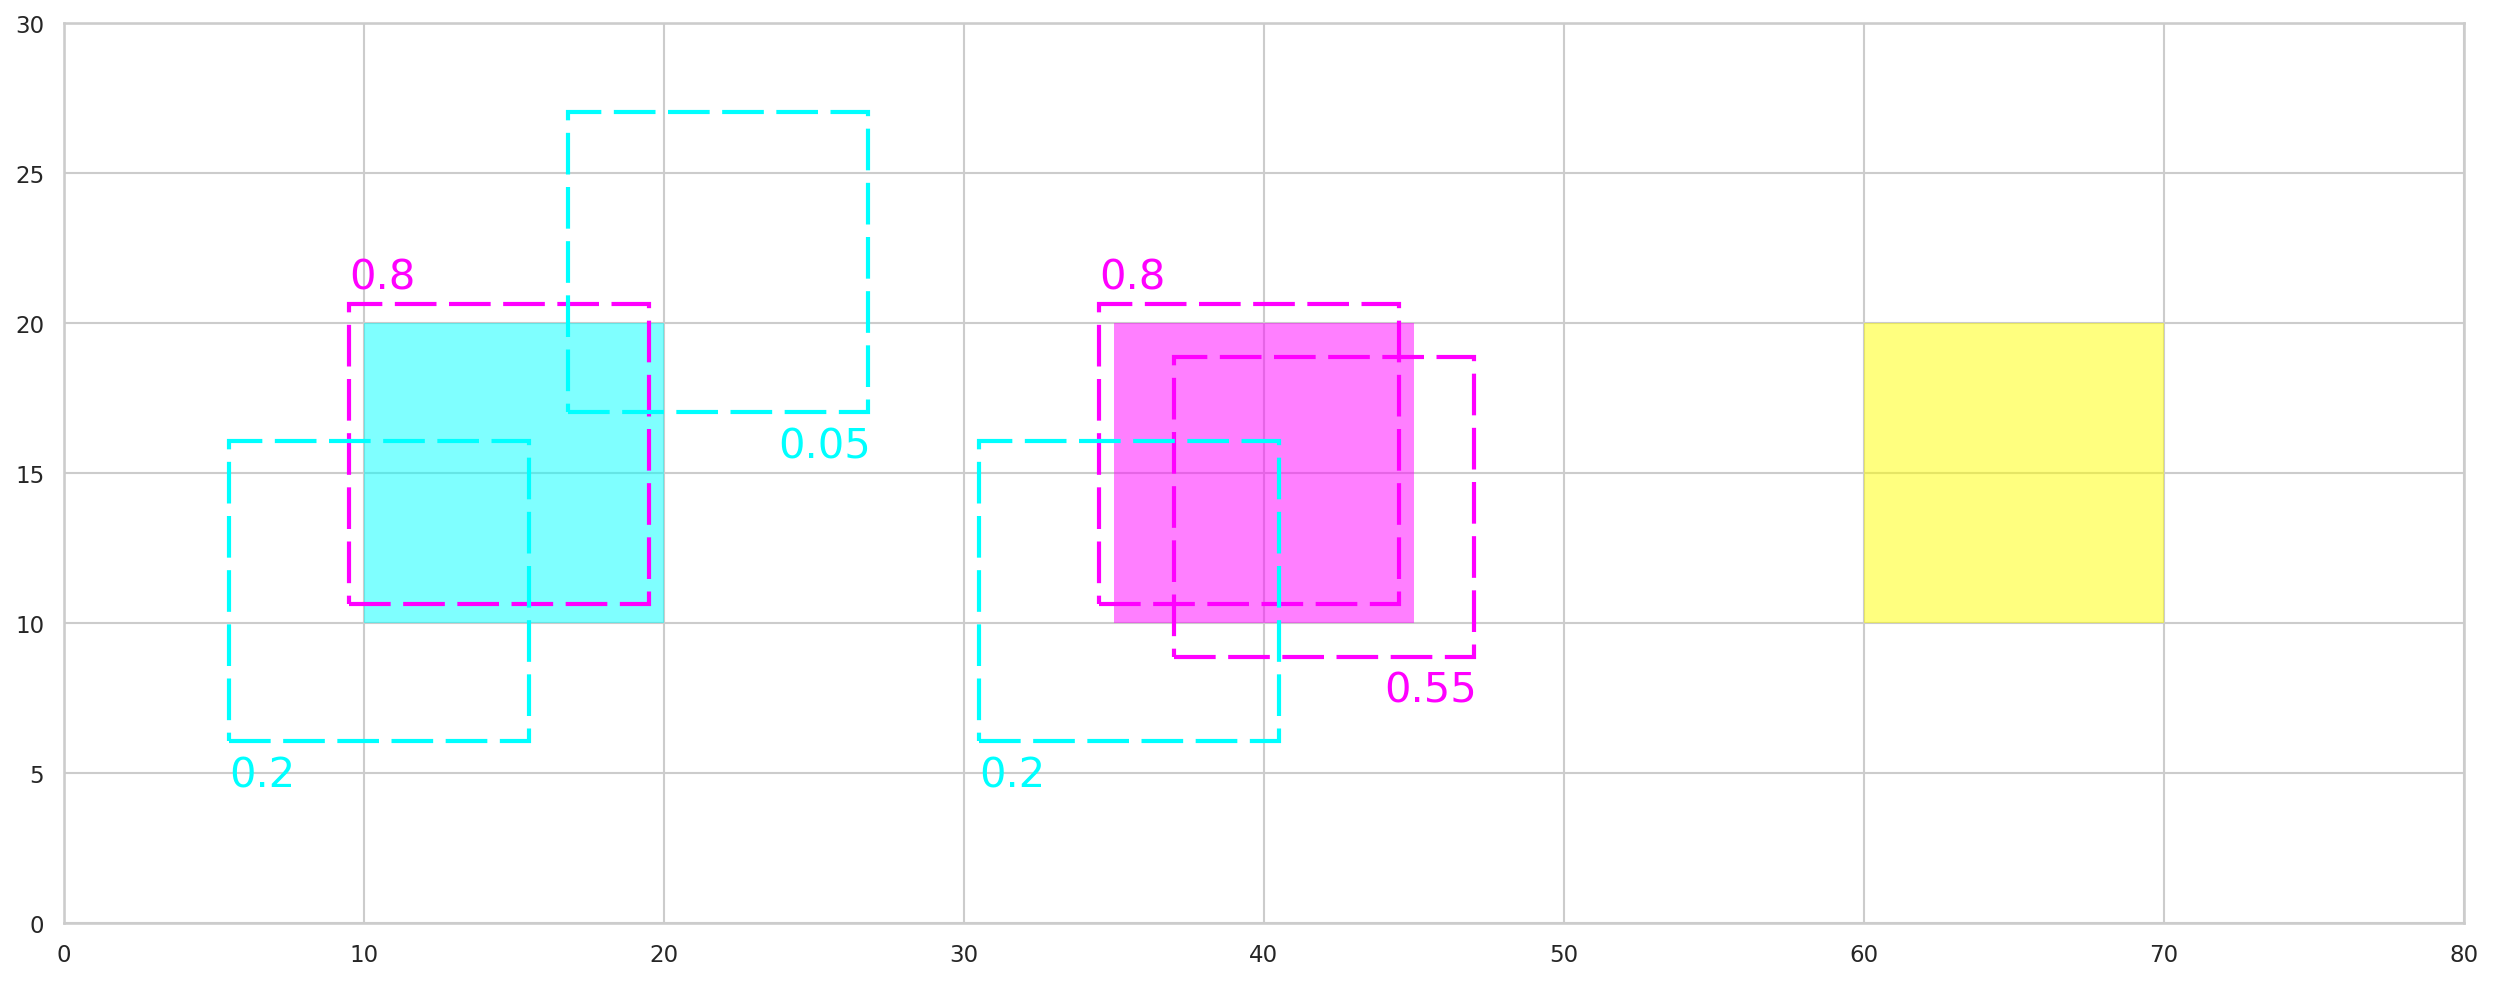

In [20]:
plot_tide_case(y_list[0], y_pred_list[0])

In [16]:
armory_output, tide = task.object_detection_mAP_tide(y_list, y_pred_list, True)
print(armory_output["errors"]["main"]["count"])
tide.summarize()

{'Cls': 1, 'Loc': 1, 'Both': 1, 'Dupe': 1, 'Bkg': 1, 'Miss': 1}
-- detection --

bbox AP @ [50-95]: 10.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      16.67    16.67    16.67    16.67    16.67    16.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    33.33     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP      16.67      -0.00  



## Fix Classification Error: `dAP = 50`
> **Classification Oracle**: Correct the class of the detection (thereby making it a true positive). If a duplicate detection would be made this way, suppress the lower scoring detection.

In [17]:
y_pred_list_Cls = [
    {
        "labels": np.array([1, 1, 1, 2, 2, 1]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Bkg,
                s_detected,
                s_Dupe,
                s_Both,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 0, 0, 1, 1, 1],
        "annotation_xy": [
            (s_Cls[0], s_Cls[3] + 0.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Bkg[2] - 3, s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[2] - 3, s_Dupe[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
        ]
    }
]

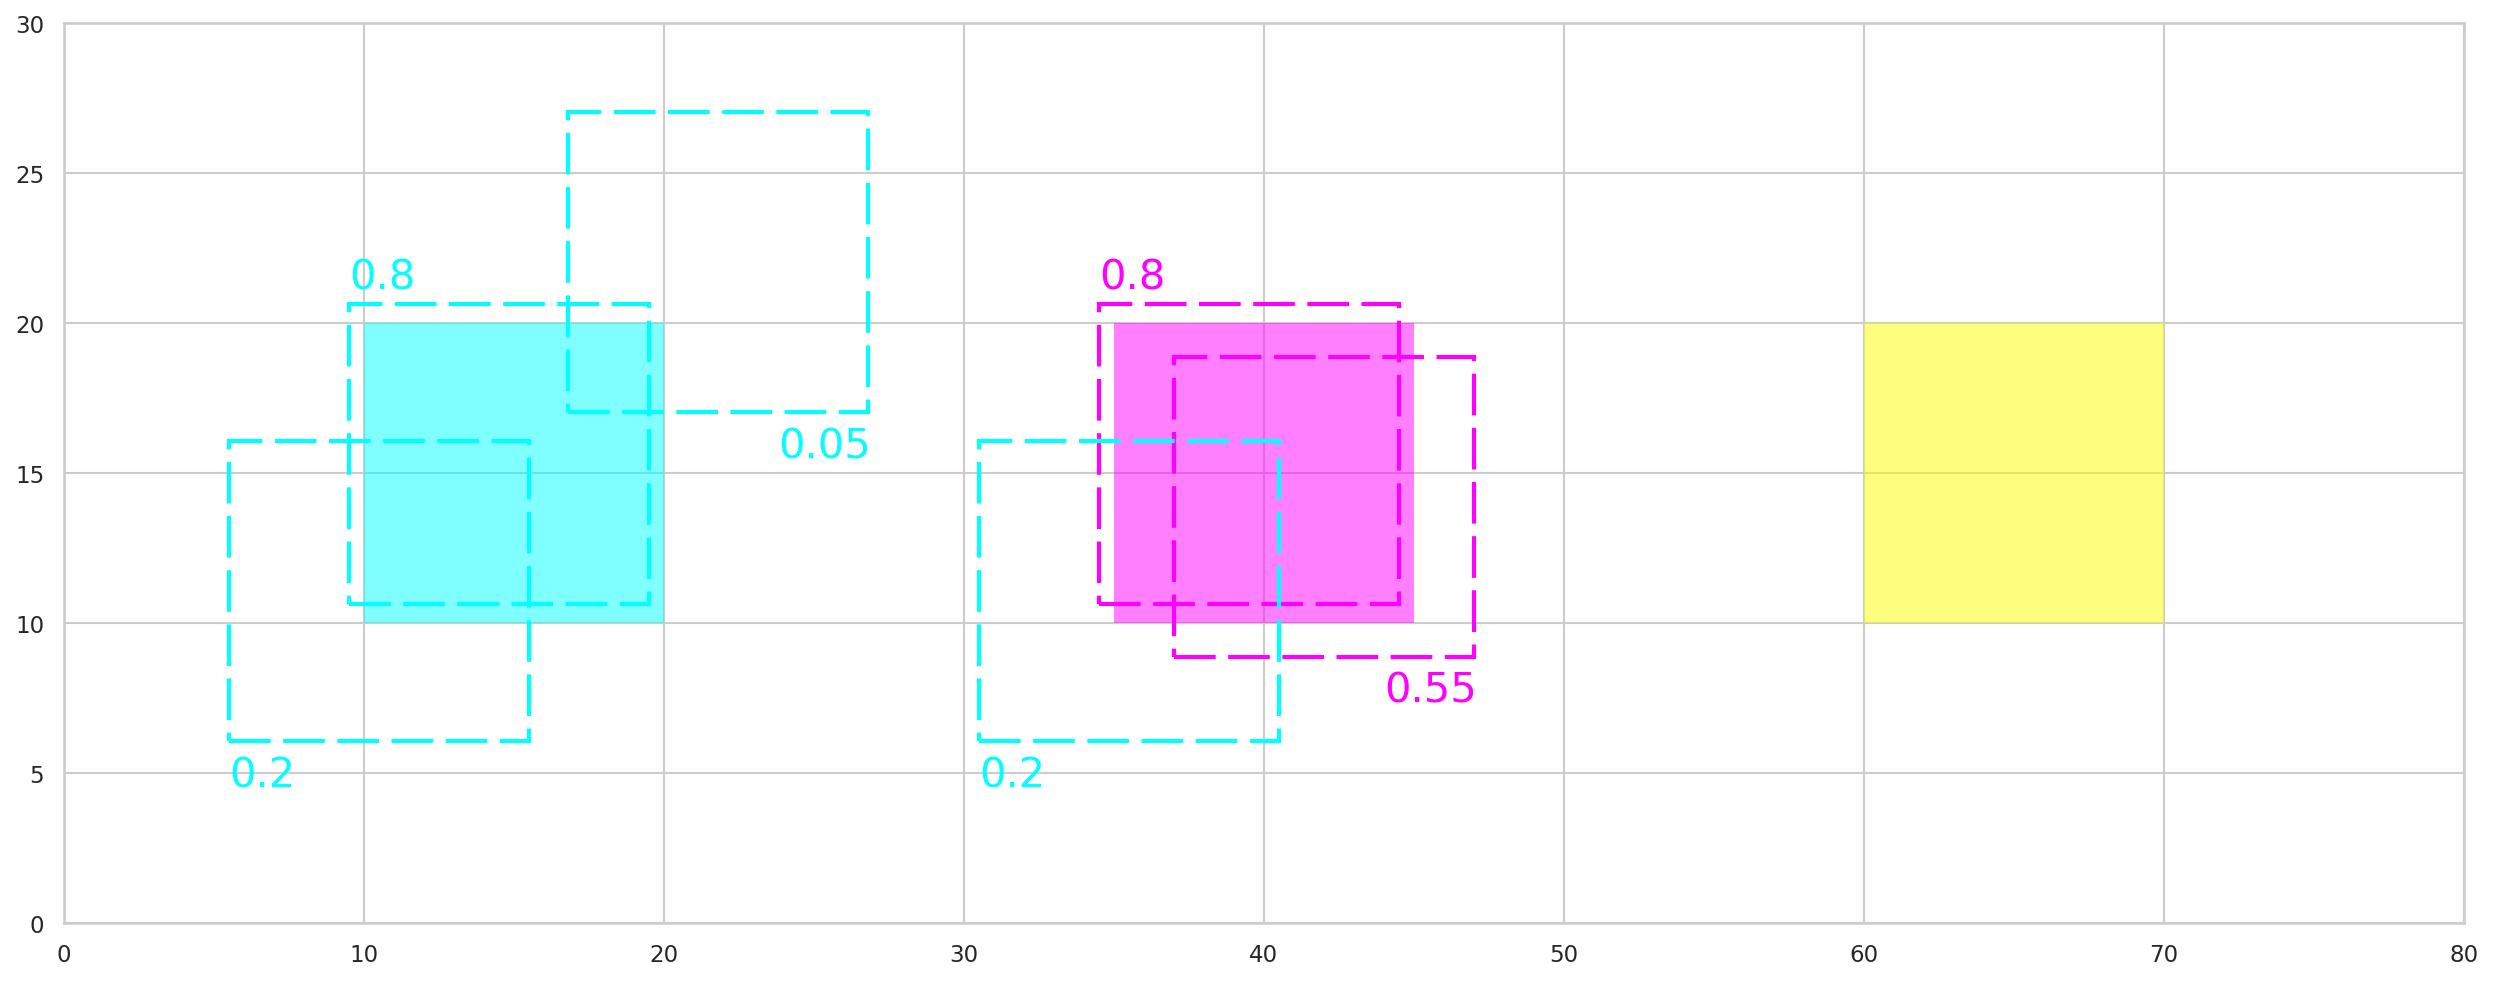

In [19]:
plot_tide_case(y_list[0], y_pred_list_Cls[0])

In [21]:
armory_output_Cls, tide_Cls = task.object_detection_mAP_tide(y_list, y_pred_list_Cls, True)
print(armory_output_Cls["errors"]["main"]["count"])
tide_Cls.summarize()

{'Cls': 0, 'Loc': 1, 'Both': 1, 'Dupe': 1, 'Bkg': 1, 'Miss': 1}
-- detection --

bbox AP @ [50-95]: 40.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      66.67    66.67    66.67    66.67    66.67    66.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00     -29.17  



## Fix Localization Error: `dAP = 33`
> **Localization Oracle**: Set the localization of the detection to the GT’s localization (thereby making it a true positive). Again, if a duplicated detection would be made this way, suppress the lower scoring detection.

In [35]:
y_pred_list_Loc = [
    {
        "labels": np.array([2, 1, 1, 2, 2, 1]),
        "boxes": np.array(
            [
                s_Cls,
                s1,
                s_Bkg,
                s_detected,
                s_Dupe,
                s_Both,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 0, 0, 1, 1, 1],
        "annotation_xy": [
            (s_Cls[0], s_Cls[3] + 0.5),
            (s1[0], s1[1] - 1.5),
            (s_Bkg[2] - 3, s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[2] - 3, s_Dupe[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
        ]
    }
]

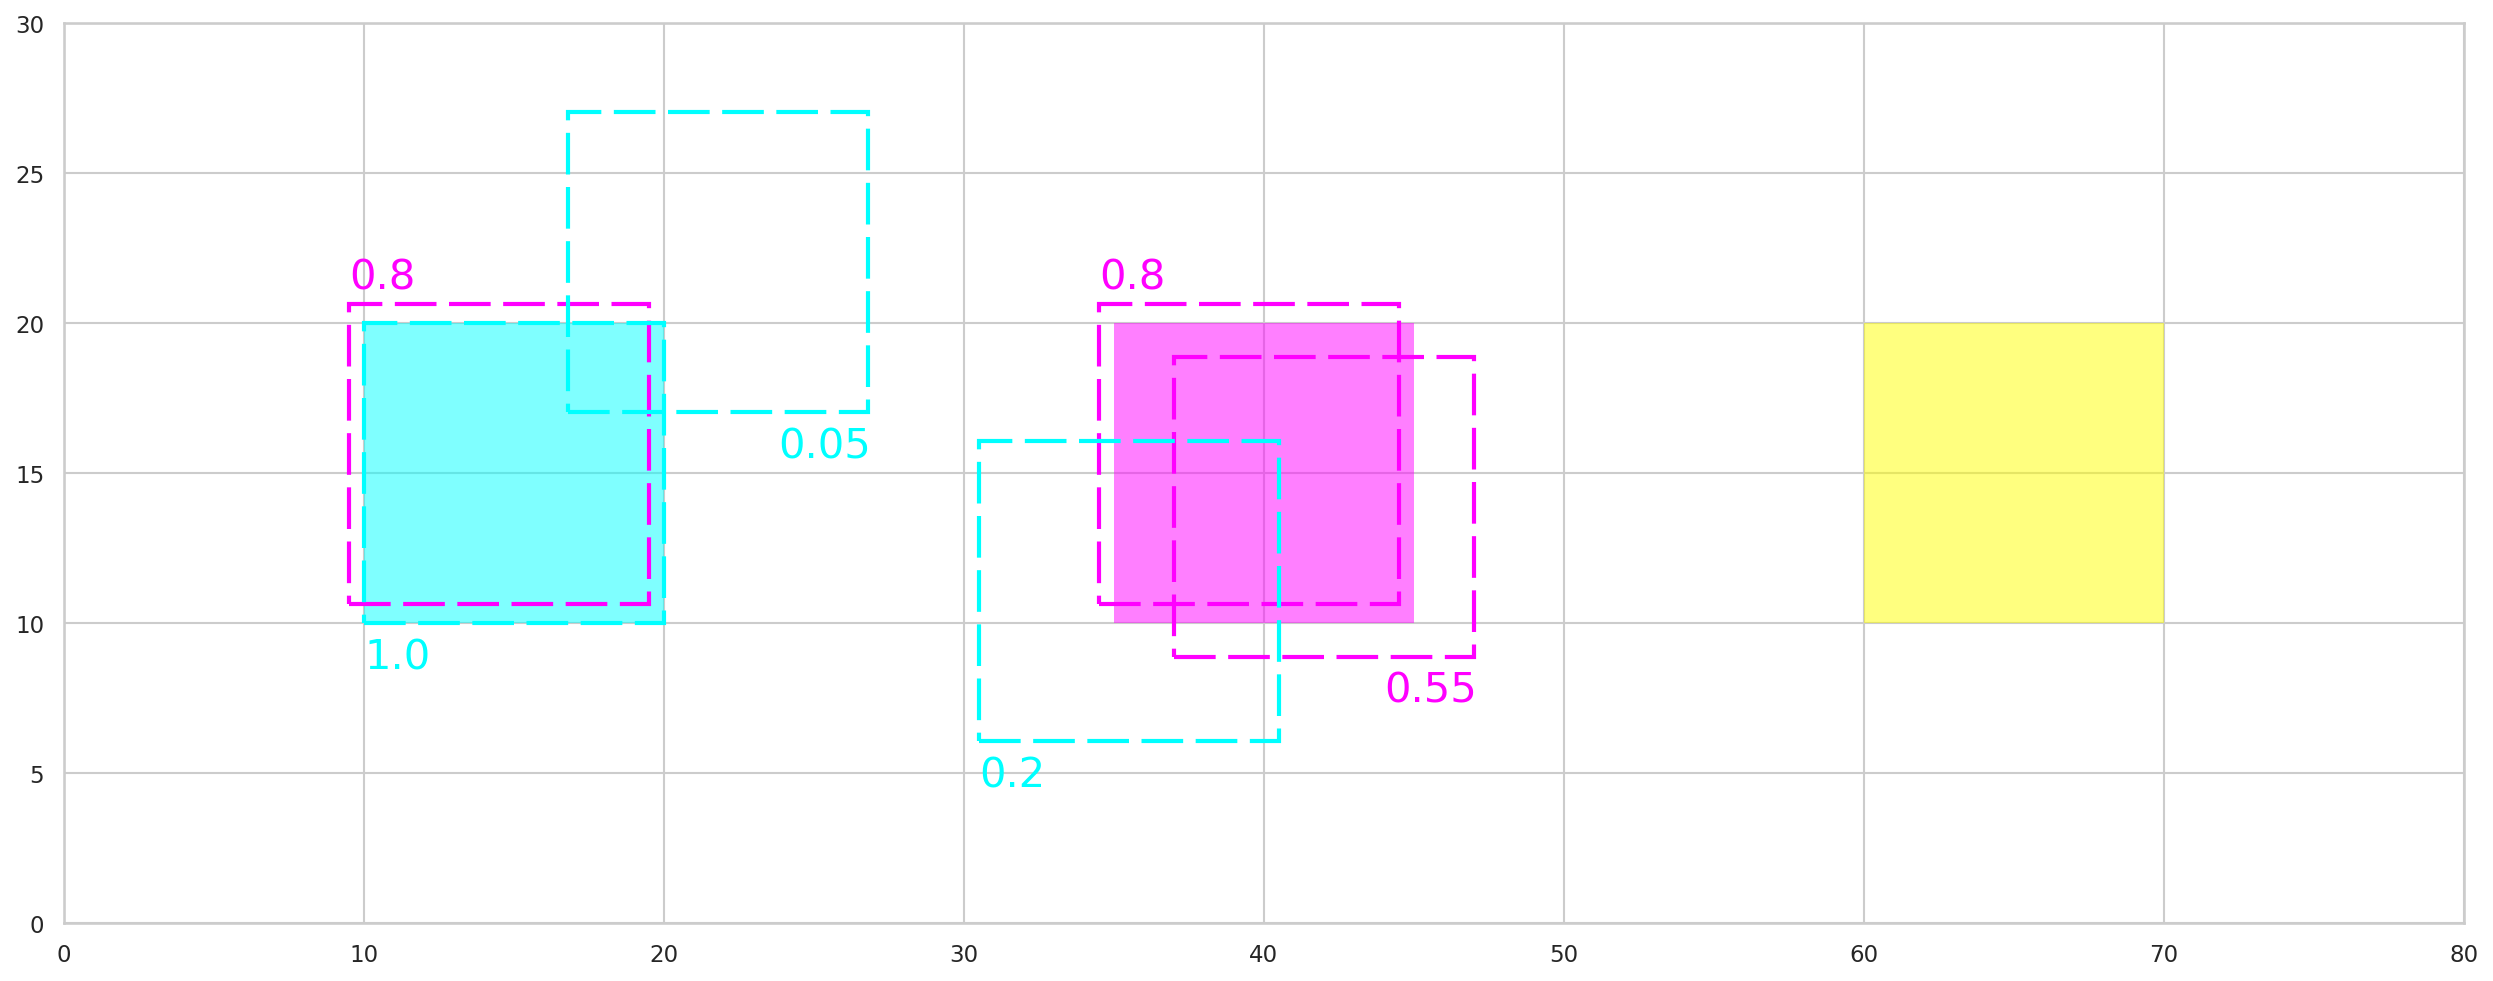

In [36]:
plot_tide_case(y_list[0], y_pred_list_Loc[0])

In [37]:
armory_output_Loc, tide_Loc = task.object_detection_mAP_tide(y_list, y_pred_list_Loc, True)
print(armory_output_Loc["errors"]["main"]["count"])
tide_Loc.summarize()

{'Cls': 1, 'Loc': 0, 'Both': 1, 'Dupe': 1, 'Bkg': 1, 'Miss': 1}
-- detection --

bbox AP @ [50-95]: 43.33
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      50.00    50.00    50.00    50.00    50.00    50.00    33.33    33.33    33.33    33.33  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP      16.67     -16.67  



## Fix Both Error: `dAP = 0`
> **Both Cls and Loc Oracle**: Since we cannot be sure of which GT the detector was attempting to match to, just suppress the false positive detection.

In [31]:
y_pred_list_Both = [
    {
        "labels": np.array([2, 1, 1, 2, 2]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Bkg,
                s_detected,
                s_Dupe,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 0, 0, 1, 1, 1],
        "annotation_xy": [
            (s_Cls[0], s_Cls[3] + 0.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Bkg[2] - 3, s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[2] - 3, s_Dupe[1] - 1.5),
        ]
    }
]

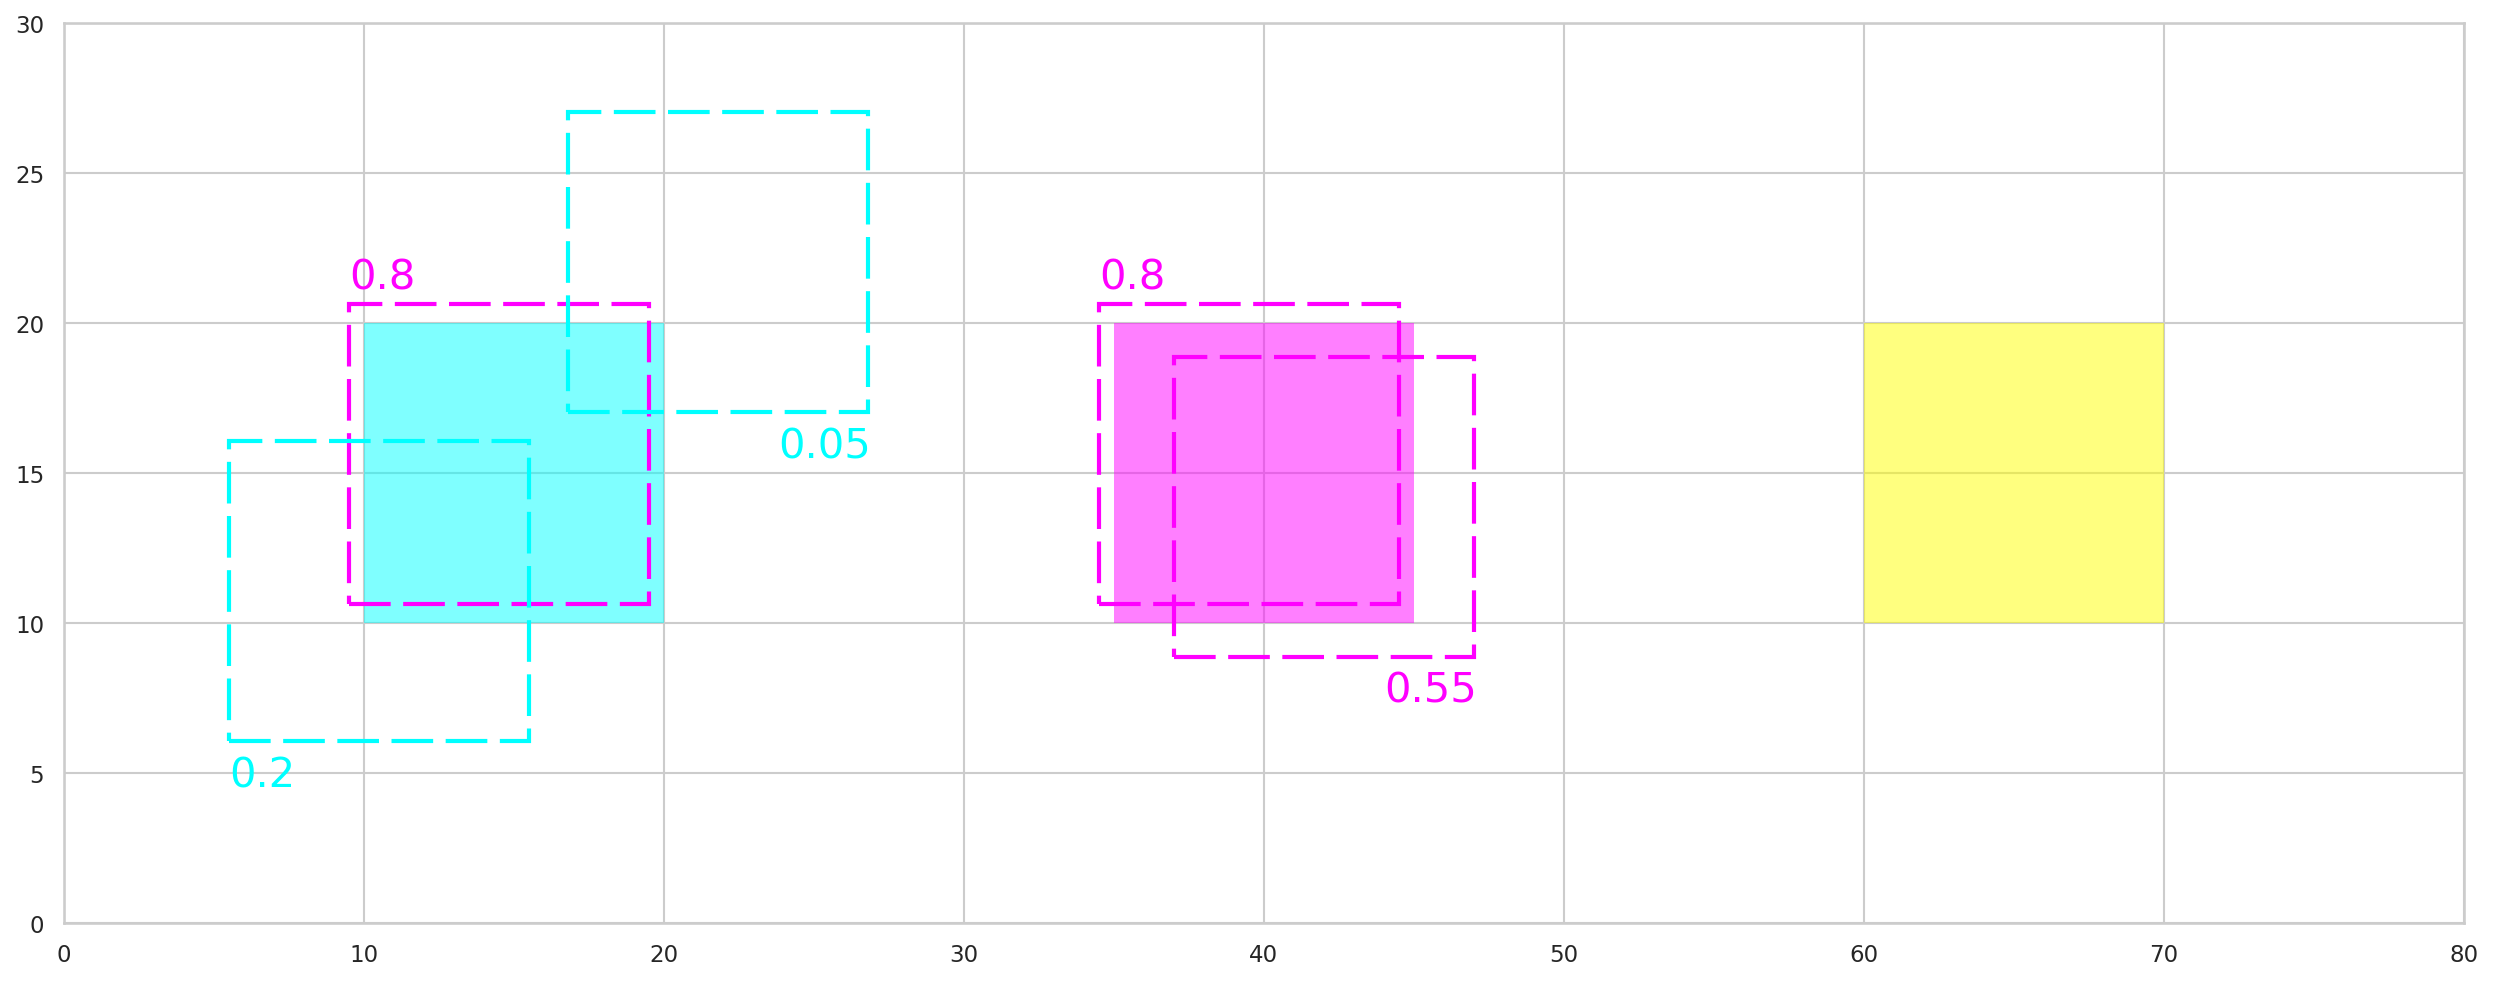

In [32]:
plot_tide_case(y_list[0], y_pred_list_Both[0])

In [33]:
armory_output_Both, tide_Both = task.object_detection_mAP_tide(y_list, y_pred_list_Both, True)
print(armory_output_Both["errors"]["main"]["count"])
tide_Both.summarize()

{'Cls': 1, 'Loc': 1, 'Both': 0, 'Dupe': 1, 'Bkg': 1, 'Miss': 1}
-- detection --

bbox AP @ [50-95]: 10.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      16.67    16.67    16.67    16.67    16.67    16.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    33.33     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP      16.67      -0.00  



## Fix Duplication Error: `dAP = 0`
> **Duplicate Detection Oracle**: Suppress the duplicate detection.

In [25]:
y_pred_list_Dupe = [
    {
        "labels": np.array([2, 1, 1, 2, 1]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_Bkg,
                s_detected,
                s_Both,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 0, 0, 1, 1],
        "annotation_xy": [
            (s_Cls[0], s_Cls[3] + 0.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_Bkg[2] - 3, s_Bkg[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Both[0], s_Both[1] - 1.5),
        ]
    }
]

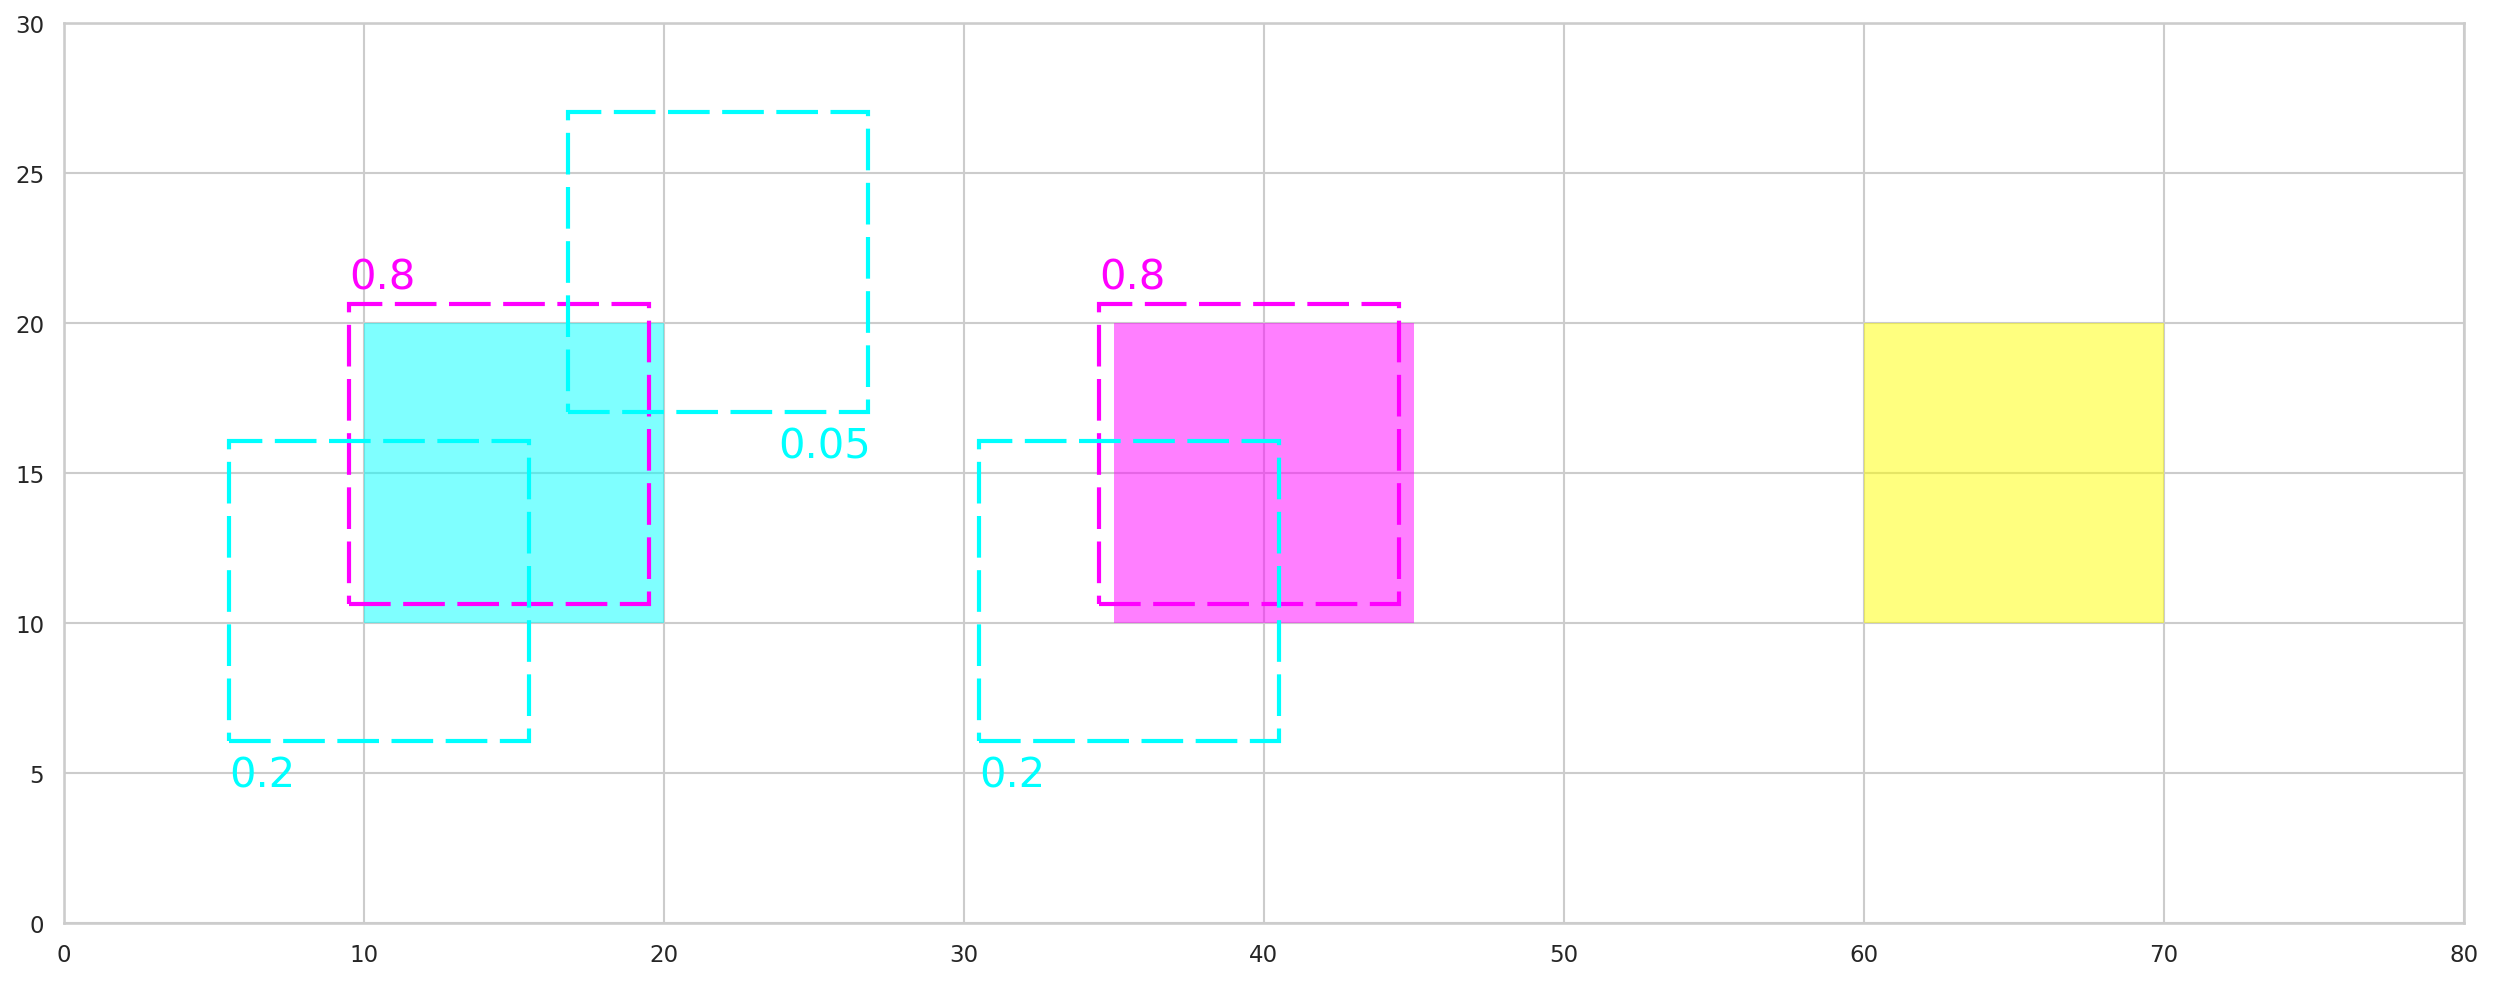

In [26]:
plot_tide_case(y_list[0], y_pred_list_Dupe[0])

In [27]:
armory_output_Dupe, tide_Dupe = task.object_detection_mAP_tide(y_list, y_pred_list_Dupe, True)
print(armory_output_Dupe["errors"]["main"]["count"])
tide_Dupe.summarize()

{'Cls': 1, 'Loc': 1, 'Both': 1, 'Dupe': 0, 'Bkg': 1, 'Miss': 1}
-- detection --

bbox AP @ [50-95]: 10.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      16.67    16.67    16.67    16.67    16.67    16.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    50.00     0.00     0.00     0.00     0.00     8.33  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP      16.67       8.33  



## Fix Background Error: `dAP = 0`
> **Background Oracle**: Suppress the hallucinated background detection.

In [42]:
y_pred_list_Bkg = [
    {
        "labels": np.array([2, 1, 2, 2, 1]),
        "boxes": np.array(
            [
                s_Cls,
                s_Loc,
                s_detected,
                s_Dupe,
                s_Both,
            ]
        ),
        "scores": np.array([0.8, 0.8, 0.8, 0.8, 0.8]),
        "max_IOU_idx": [0, 0, 1, 1, 1],
        "annotation_xy": [
            (s_Cls[0], s_Cls[3] + 0.5),
            (s_Loc[0], s_Loc[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
            (s_Dupe[2] - 3, s_Dupe[1] - 1.5),
            (s_Both[0], s_Both[1] - 1.5),
        ]
    }
]

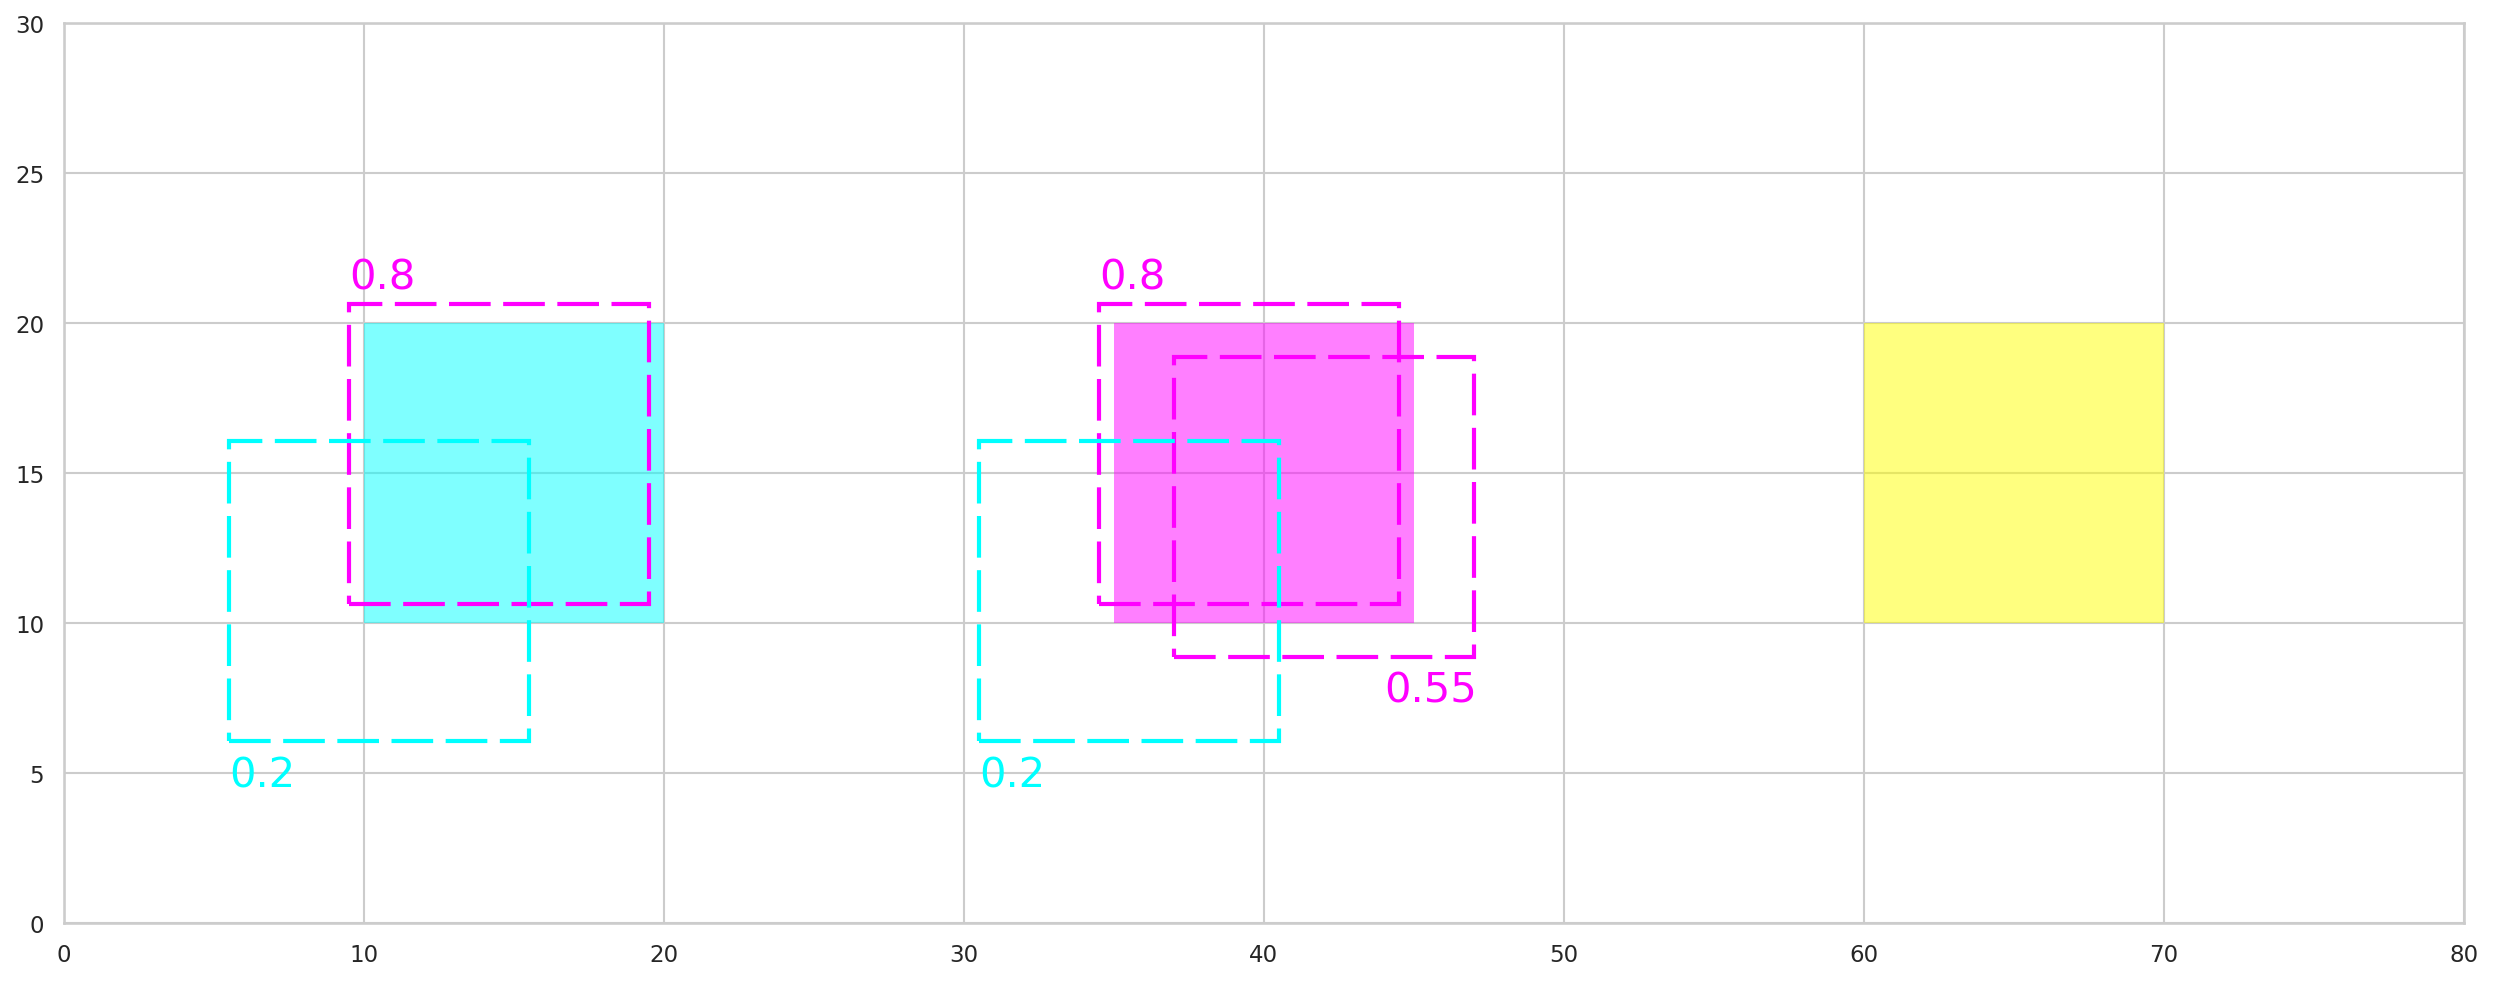

In [43]:
plot_tide_case(y_list[0], y_pred_list_Bkg[0])

In [44]:
armory_output_Bkg, tide_Bkg = task.object_detection_mAP_tide(y_list, y_pred_list_Bkg, True)
print(armory_output_Bkg["errors"]["main"]["count"])
tide_Bkg.summarize()

{'Cls': 1, 'Loc': 1, 'Both': 1, 'Dupe': 1, 'Bkg': 0, 'Miss': 1}
-- detection --

bbox AP @ [50-95]: 10.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      16.67    16.67    16.67    16.67    16.67    16.67     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    33.33     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP      16.67      -0.00  



## Fix Missed Error: `dAP = 8`
> **Missed GT Oracle**: Reduce the number of GT (*N<sub>GT</sub>*) in the *mAP* calculation by the number of missed ground truth. This has the effect of stretching the precision-recall curve over a higher recall, essentially acting as if the detector was equally as precise on the missing GT. The alternative to this would be to add new detections, but it’s not clear what the score should be for that new detection such that it doesn’t introduce confounding variables. We discuss this choice further in the Appendix.

In [28]:
y_list_Miss = [
        {
        "labels": np.array([1, 2]),
        "boxes": np.array(
            [
                s1,
                s2,
            ]
        ),
    }
]

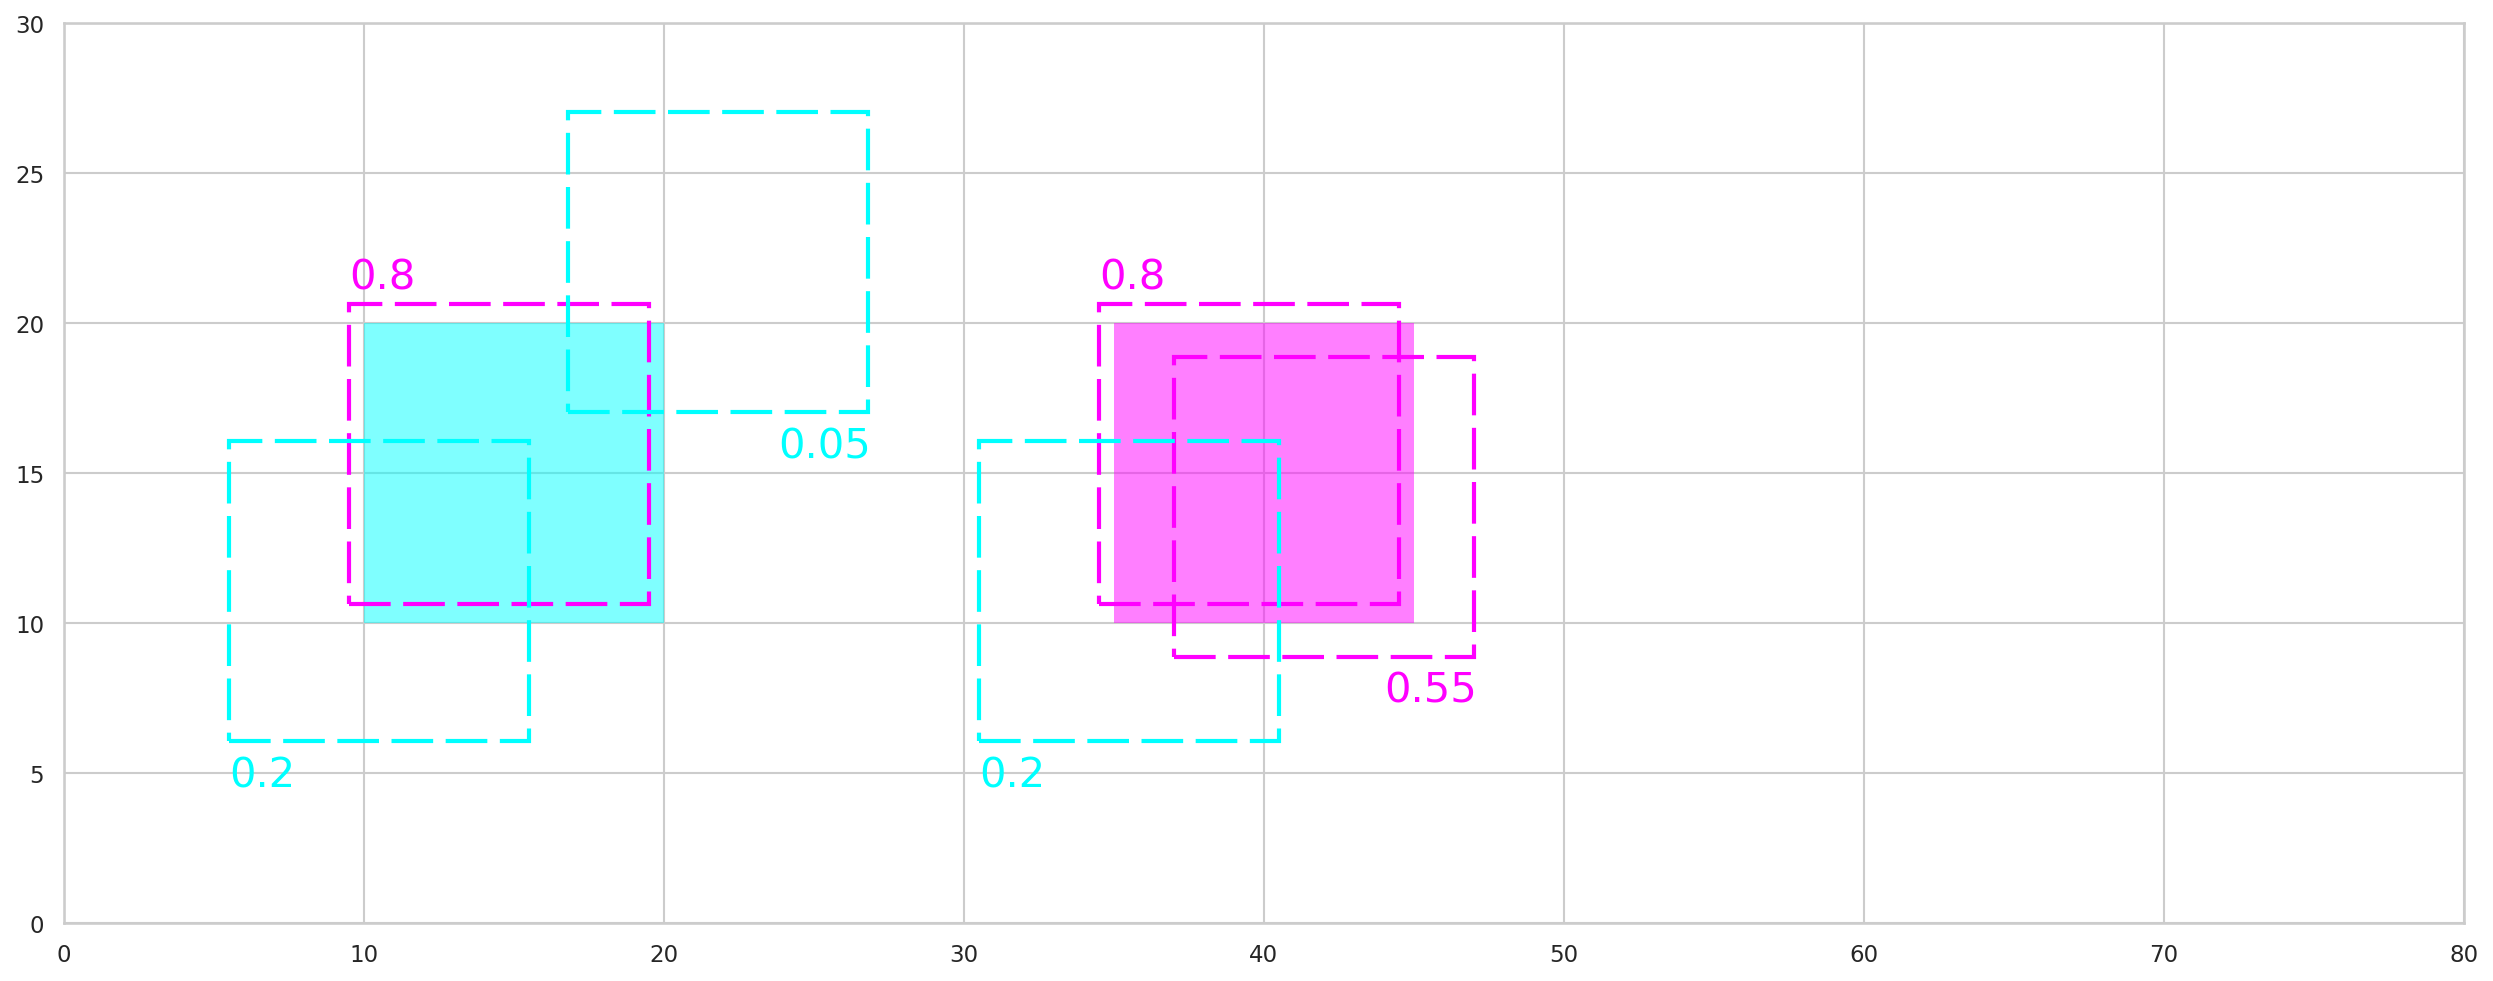

In [29]:
plot_tide_case(y_list_Miss[0], y_pred_list[0])

In [30]:
armory_output_Miss, tide_Miss = task.object_detection_mAP_tide(y_list_Miss, y_pred_list, True)
print(armory_output_Miss["errors"]["main"]["count"])
tide_Miss.summarize()

{'Cls': 1, 'Loc': 1, 'Both': 1, 'Dupe': 1, 'Bkg': 1, 'Miss': 0}
-- detection --

bbox AP @ [50-95]: 15.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      25.00    25.00    25.00    25.00    25.00    25.00     0.00     0.00     0.00     0.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    50.00     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP      25.00      -8.33  



## Fix All Errors: `dAP = 83`
Assume an order where duplication errors are fixed last in case fixing a classification error or localization error causes a duplicate error

In [38]:
y_pred_list_All = [
    {
        "labels": np.array([1, 2]),
        "boxes": np.array(
            [
                s1,
                s_detected,
            ]
        ),
        "scores": np.array([0.8, 0.8]),
        "max_IOU_idx": [0, 1],
        "annotation_xy": [
            (s1[0], s1[1] - 1.5),
            (s_detected[0], s_detected[3] + 0.5),
        ]
    }
]

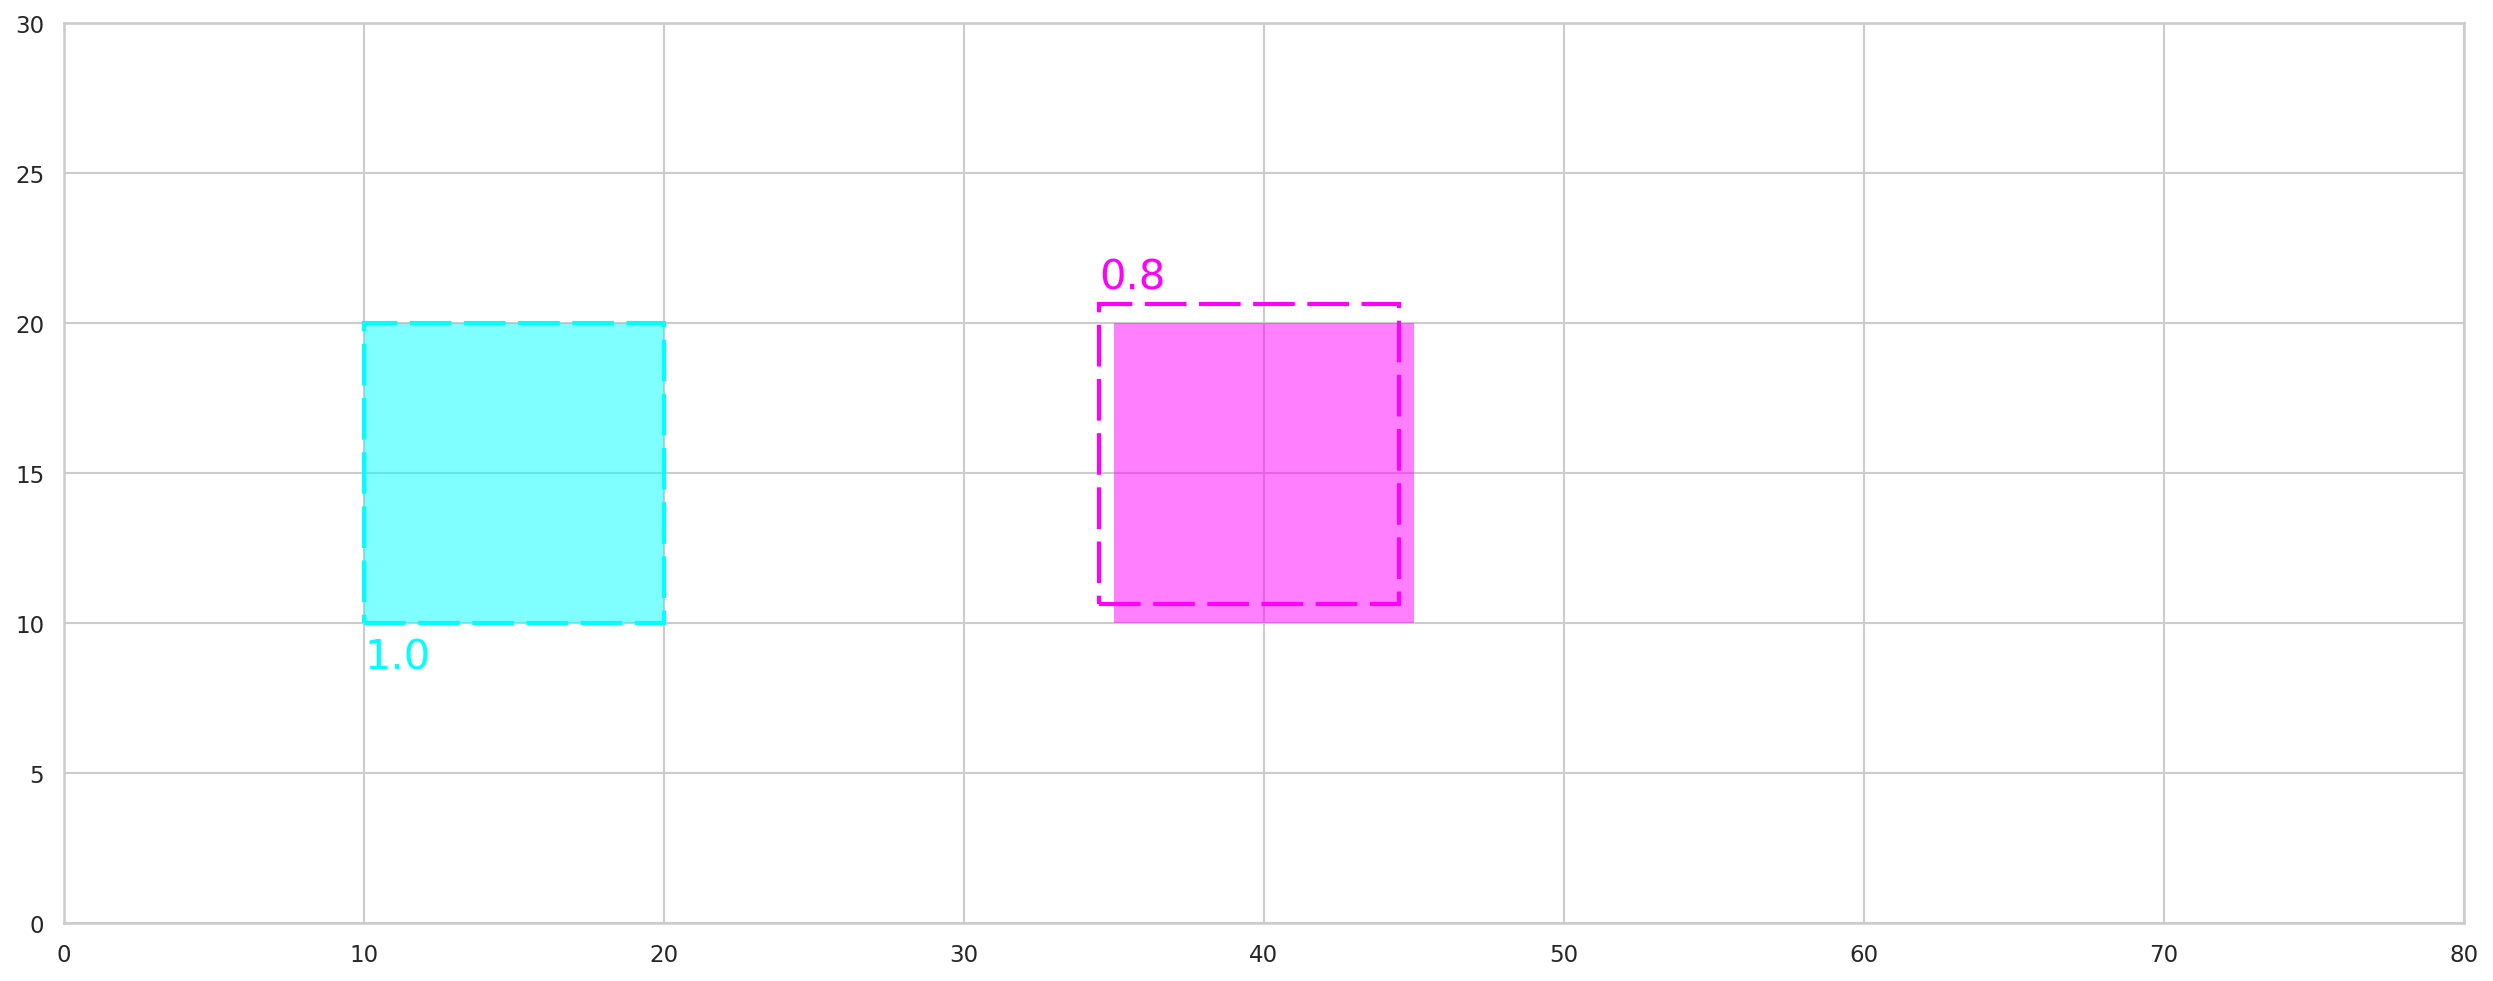

In [40]:
plot_tide_case(y_list_Miss[0], y_pred_list_All[0])

In [41]:
armory_output_All, tide_All = task.object_detection_mAP_tide(y_list_Miss, y_pred_list_All, True)
print(armory_output_All["errors"]["main"]["count"])
tide_All.summarize()

{'Cls': 0, 'Loc': 0, 'Both': 0, 'Dupe': 0, 'Bkg': 0, 'Miss': 0}
-- detection --

bbox AP @ [50-95]: 80.00
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP     100.00   100.00   100.00   100.00   100.00   100.00    50.00    50.00    50.00    50.00  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00       0.00  



## Miscellaneous

In [17]:
s_Cls_dict = {"labels": 2, "boxes": s_Cls, "scores": 0.8, "annotation_xy": (s_Cls[0], s_Cls[3] + 0.5)}
s_Loc_dict = {"labels": 1, "boxes": s_Loc, "scores": 0.8, "annotation_xy": (s_Loc[0], s_Loc[1] - 1.5)}
s_Bkg_dict = {"labels": 1, "boxes": s_Bkg, "scores": 0.8, "annotation_xy": (s_Bkg[2] - 3, s_Bkg[1] - 1.5)}
s_detected_dict = {"labels": 2, "boxes": s_detected, "scores": 0.8, "annotation_xy": (s_detected[0], s_detected[3] + 0.5)}
s_Dupe_dict = {"labels": 2, "boxes": s_Dupe, "scores": 0.8, "annotation_xy": (s_Dupe[2] - 3, s_Dupe[1] - 1.5)}
s_Both_dict = {"labels": 1, "boxes": s_Both, "scores": 0.8, "annotation_xy": (s_Both[0], s_Both[1] - 1.5)}

In [18]:
Y_pred_list = [s_Cls_dict, s_Loc_dict, s_Bkg_dict, s_detected_dict, s_Dupe_dict, s_Both_dict]